# Brain Tumour Image Segmentation 

Using Kaggle brain tumour dataset


## Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline


2024-04-26 08:14:03.793635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_path = "data/kaggle_3m/" 
brain_df = pd.read_csv(data_path+'data_mask.csv')

In [3]:
brain_df.info() 
brain_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [4]:
brain_df.mask_path[1] 
# brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [5]:
brain_df['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

Imbalanced data - oh well 

## Data visualisation


In [8]:
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

In [7]:
# Plot bar chart using plotly 

import plotly.graph_objects as go 

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)', marker_line_width = 7, opacity = 0.6)
fig.show()

In [ ]:
plt.imshow(cv2.imread(data_path+brain_df.mask_path[623]))

In [ ]:
plt.imshow(cv2.imread(data_path+brain_df.image_path[623]))


In [ ]:
cv2.imread(data_path+brain_df.mask_path[623]).max()


In [ ]:
cv2.imread(data_path+brain_df.mask_path[623]).min()


In [ ]:
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(data_path+brain_df.image_path[i])) # show MRI
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(data_path+brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()


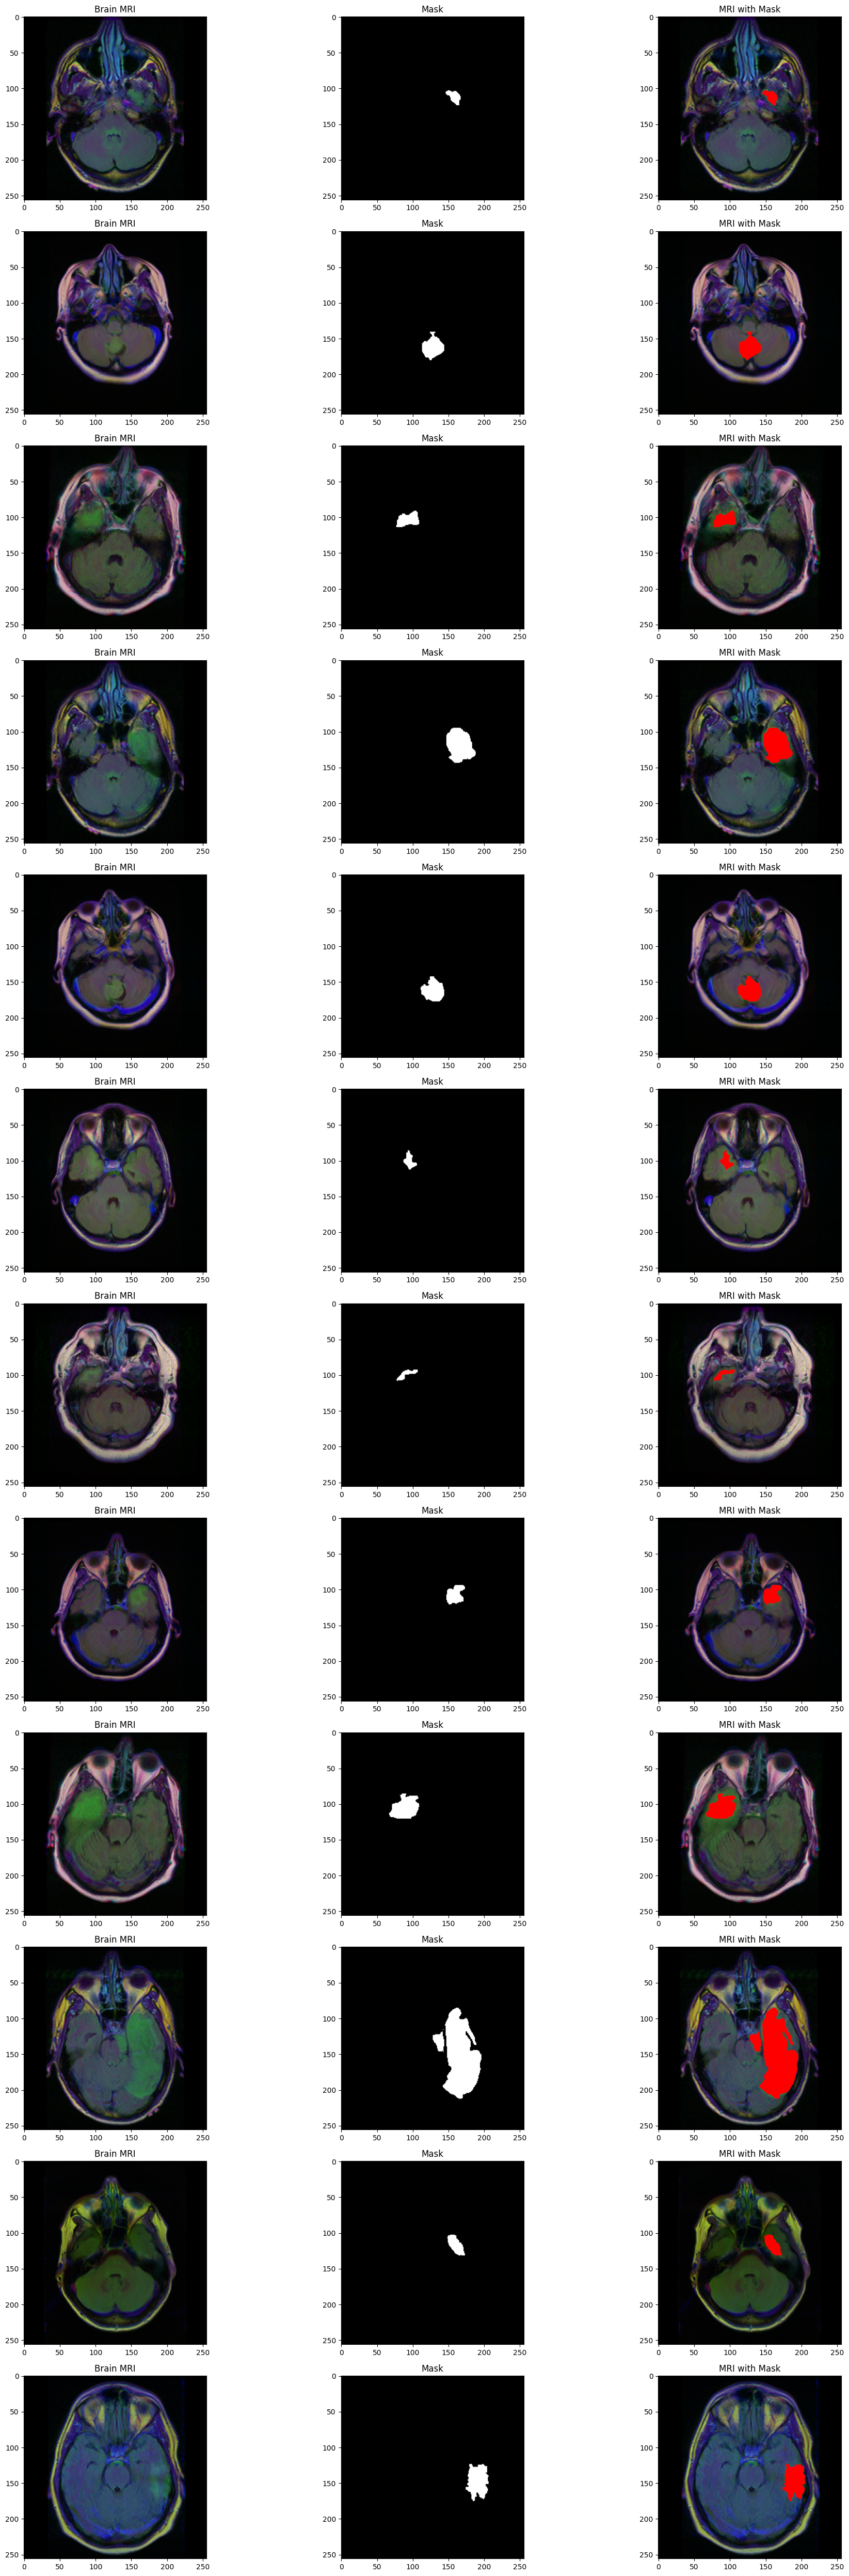

In [79]:
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images
    img = io.imread(data_path+brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image
    mask = io.imread(data_path+brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')

    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255
    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()


In [7]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [8]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [9]:
from sklearn.model_selection import train_test_split 

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [10]:
# !pip install keras_preprocessing

In [11]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [12]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= data_path+'./',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= data_path+'./',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= data_path+'./',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))


Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [15]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [31]:
basemodel.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 64, 64, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 32, 32, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 32, 32, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 16, 16, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 16, 16, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 16, 16, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)                                                                                           
          

In [16]:
for layer in basemodel.layers:
  layers.trainable = False


In [17]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel) # Binary classification

model = Model(inputs = basemodel.input, outputs = headmodel)


In [18]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 64, 64, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 32, 32, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 32, 32, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 16, 16, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 16, 16, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 16, 16, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])



In [20]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.keras", verbose=1, save_best_only=True)
     


In [68]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 15, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])


Epoch 1/15
177/177 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.8452
Epoch 1: val_loss improved from inf to 104.76376, saving model to classifier-resnet-weights.keras
177/177 [==============================] - 1123s 6s/step - loss: 0.4152 - accuracy: 0.8452 - val_loss: 104.7638 - val_accuracy: 0.6371
Epoch 2/15
177/177 [==============================] - ETA: 0s - loss: 0.3609 - accuracy: 0.8714
Epoch 2: val_loss improved from 104.76376 to 1.89083, saving model to classifier-resnet-weights.keras
177/177 [==============================] - 1192s 7s/step - loss: 0.3609 - accuracy: 0.8714 - val_loss: 1.8908 - val_accuracy: 0.6028
Epoch 3/15
177/177 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.8721
Epoch 3: val_loss improved from 1.89083 to 0.59847, saving model to classifier-resnet-weights.keras
177/177 [==============================] - 1117s 6s/step - loss: 0.3337 - accuracy: 0.8721 - val_loss: 0.5985 - val_accuracy: 0.8448
Epoch 4/15


In [69]:
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [70]:
# load the model
model = tf.keras.models.model_from_json(model_json)
model.load_weights('classifier-resnet-weights.keras')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])


In [71]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)


36/36 [==============================] - 50s 1s/step


In [72]:
test_predict.shape

(576, 2)

In [73]:
test_predict

array([[4.0692957e-03, 9.9593079e-01],
       [9.9916536e-01, 8.3459308e-04],
       [9.9805456e-01, 1.9454326e-03],
       ...,
       [4.8954997e-02, 9.5104504e-01],
       [5.1378953e-01, 4.8621044e-01],
       [9.9714565e-01, 2.8543128e-03]], dtype=float32)

In [74]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)


In [75]:
predict


array(['1', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0',
       '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1',
       '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1',
       '0', '1', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1',
       '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '1', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1',
       '1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1',
       '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0',
       '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0',
       '0', '1', '0', '0', '0', '1', '1', '1', '1', '0', '1', '0

In [76]:

# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy
     

0.921875

<Axes: >

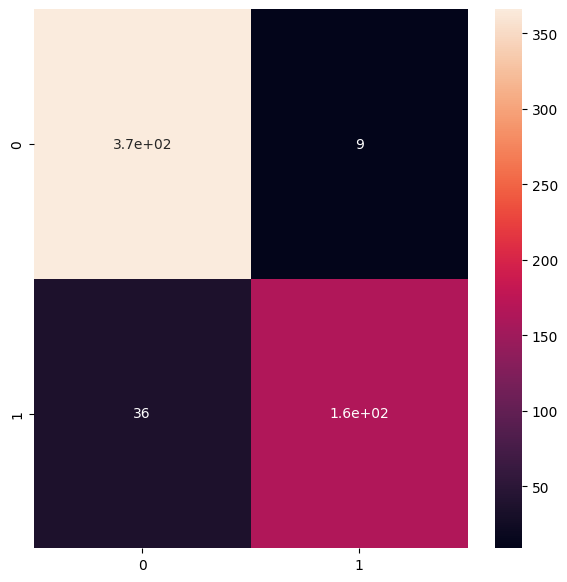

In [77]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)


In [78]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       375
           1       0.95      0.82      0.88       201

   micro avg       0.92      0.92      0.92       576
   macro avg       0.93      0.90      0.91       576
weighted avg       0.92      0.92      0.92       576



/usr/local/lib/python3.10/site-packages/numpy/lib/arraysetops.py:729: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.10/site-packages/numpy/lib/arraysetops.py:729: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.10/site-packages/numpy/lib/arraysetops.py:729: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.10/site-packages/numpy/lib/arraysetops.py:729: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [13]:
# Segmentation model 

brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [14]:
from sklearn.model_selection import train_test_split 

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15) 
X_test, X_val = train_test_split(X_val, test_size = 0.5)




In [15]:
train_ids = list(data_path+X_train.image_path)
train_mask = list(data_path+X_train.mask_path)

val_ids = list(data_path+X_val.image_path)
val_mask = list(data_path+X_val.mask_path)



In [16]:
from utilities import DataGenerator 

training_generator = DataGenerator(train_ids, train_mask)
validation_generator = DataGenerator(val_ids, val_mask)

In [17]:
def resblock(X, f):


  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X
     


In [18]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [19]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [20]:
model_seg.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['batch_normalization[0][0

                                                                                                  
 batch_normalization_9 (Bat  (None, 32, 32, 128)          512       ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 32, 32, 128)          512       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 add_2 (Add)                 (None, 32, 32, 128)          0         ['batch_normalization_9[0][0]'
                                                                    , 'batch_normalization_10[0][0
                                                                    ]']                           
          

 activation_10 (Activation)  (None, 64, 64, 64)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 64, 64, 64)           36928     ['activation_10[0][0]']       
                                                                                                  
 conv2d_19 (Conv2D)          (None, 64, 64, 64)           12352     ['concatenate_1[0][0]']       
                                                                                                  
 batch_normalization_18 (Ba  (None, 64, 64, 64)           256       ['conv2d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_nor

 conv2d_26 (Conv2D)          (None, 256, 256, 1)          17        ['activation_15[0][0]']       
                                                                                                  
Total params: 1210513 (4.62 MB)
Trainable params: 1206129 (4.60 MB)
Non-trainable params: 4384 (17.12 KB)
__________________________________________________________________________________________________


In [21]:
from utilities import focal_tversky, tversky_loss, tversky
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])


In [22]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)
     


In [23]:
history = model_seg.fit(training_generator, epochs = 15, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])


Epoch 1/15
72/72 [==============================] - ETA: 0s - loss: 0.7913 - tversky: 0.2649
Epoch 1: val_loss improved from inf to 0.75231, saving model to ResUNet-weights.hdf5


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 270s 4s/step - loss: 0.7913 - tversky: 0.2649 - val_loss: 0.7523 - val_tversky: 0.3155
Epoch 2/15
72/72 [==============================] - ETA: 0s - loss: 0.4671 - tversky: 0.6347
Epoch 2: val_loss improved from 0.75231 to 0.53846, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 269s 4s/step - loss: 0.4671 - tversky: 0.6347 - val_loss: 0.5385 - val_tversky: 0.5616
Epoch 3/15
72/72 [==============================] - ETA: 0s - loss: 0.3991 - tversky: 0.7038
Epoch 3: val_loss improved from 0.53846 to 0.40795, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 261s 4s/step - loss: 0.3991 - tversky: 0.7038 - val_loss: 0.4079 - val_tversky: 0.6969
Epoch 4/15
72/72 [==============================] - ETA: 0s - loss: 0.3350 - tversky: 0.7651
Epoch 4: val_loss improved from 0.40795 to 0.38003, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 292s 4s/step - loss: 0.3350 -